In [131]:
# Data-driven Newsvendor with Pricing
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [132]:
#Initalization
a = 0 #y-intercept or market size
b = 0 #coefficient of price
p = [] #price sampling
D = [] #demand sampling
u = [] #estimation error term sampling
sigma = 0 #std of estimation error terms sampling


In [133]:
#Parameters for example illustration
n = 200 #sample size
cv = 0.5 #coefficient of variance
c = 0.5 #procurement cost per unit
alpha = 0.9 #non-stockout probability

#Sampling range
lbp = 1 #lower bound of price
ubp = 1.5 #upper bound of price
lba = 1500 #lb of a
uba = 2000 #up of a
lbb = 500 #lb of b
ubb = 1000 #ub of b

# IMPLEMENTATION

We can divide the main problem into two subproblems as follows:  
1) to learn the relationship between demand/ ordering quantity and price   
2) to find optimal quantity and price   


## DEMAND/ ORDERING QUANTITY ESTIMATION (BEUTEL 2012)

**Reference:** Beutel, A. L., & Minner, S. (2012). *Safety stock planning under causal demand forecasting*. International Journal of Production Economics, 140(2), 637-645.

### Function to generate sampling of demand and price:
Demand is presented here as a function of price p: D(p) = a - b\*p + u.  
Demand - price observation set is built by randomly choose a, b, p and u. In more detail:
- market size a ~ U(1500, 2000)
- slope b ~ U(500, 1000)
- uniformly chosen sample of price p (with size = sampleSize) in range [1, 1.5] 
- D equals to the sum of prediction value plus estimation error u ~ N(0, sigma). Sigma is chosen so that the coefficient of variation at mean price p equals coefVar.

It should be noticed that here we will focus on the case that demand is relatively elastic with price. The reason is that in case of relatively price elasticity, demand responds weakly with the changes of price. Therefore, the vendor has the incentive to increase price as much as possible while only facing a little decrease in demand quantity. Combining with a ratio between overage and underage cost that is low enough (co < cu), it may lead to an ordering quantity function increasing with price increase and an unbound problem in price-setting newsvendor problem. Therefore, in the sampling generation function, we will reject the sample with relatively low price elasticity (<1) by checking the arc elasticity over the defined price range from OLS linear regression demand function.


In [134]:
# Demand - Price generation
def samplingDemand(sampleSize, coefVar):
    
    global a, b, p, D, u, sigma
    a = 0; b = 0; p = []; D = []; u = []; sigma = 0;
    
    lowElasticity = True
    while lowElasticity:
        a = np.random.uniform(low = lba, high = uba)
        b = np.random.uniform(low = lbb, high = ubb)
        p = np.random.uniform(size = [sampleSize, 1])*(ubp - lbp) + lbp # uniformly chosen in price range [1, 1.5]

        meanP = np.mean(p)
        sigma = (a - b*meanP)*coefVar
        u = np.zeros(shape = (sampleSize,))
        D = np.repeat(-1, repeats = sampleSize)
        for i in range(sampleSize):
            while D[i] < 0:
                u[i] = np.random.normal(loc = 0, scale = sigma)
                D[i] = a - b*p[i] + u[i]
 

        #check Arc price elasticity
        # OLS Linear regression for comparison
        reg = linear_model.LinearRegression().fit(p, D)
        coef2 = reg.coef_
        coef1 = reg.intercept_
        Q1 = coef1 + coef2*lbp
        Q2 = coef1 + coef2*ubp
        arcElasticity = ((lbp + ubp) / (Q1 + Q2)) * ((Q2 - Q1) / (ubp - lbp))
        if abs(arcElasticity) >= 1: lowElasticity = False
    
    return coef1, coef2

Sampling example:

Text(0.5, 1.0, 'Demand sampling')

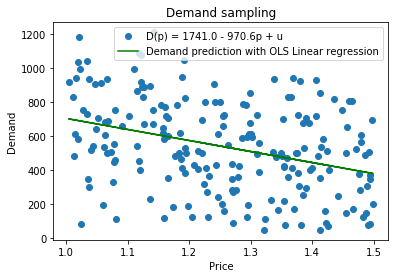

In [135]:
coef1, coef2 = samplingDemand(sampleSize = n, coefVar = cv)
plt.plot(p,D, 'o', label = 'D(p) = ' + str(round(a,0)) + ' - ' + str(round(b,2)) + 'p + u')
plt.plot(p, coef1 + coef2*p, 'g-', label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.legend()
plt.title('Demand sampling')

### Optimization model to find the ordering quantity as a function of price
Here we use the approach presented in Beutel (2012) that integrates demand estimation and ordering optimization in a single model (instead of sequential steps) to learn about the relationship between ordering quantity and price. The main idea is to predict the ordering quantity by exploring historical data of demand-price with consideration of the overage and underage costs during estimating (i.e. different weights applied to the positive/negative errors in regression).  
  
There is a slight difference in two models below to the base models in Beutel (2012). In her models, Beutel assumes fixed holding cost and penalty cost, representing the overage and underage cost respectively. In other words, these costs are **independent with selling price**. However, here we will define the overage and underage cost as in the traditional newsvendor model, i.e.:     
- overage cost (co) = procurement cost (c)
- underage cost (cu) = selling price - procurement cost (p-c)

Therefore, the underage cost and so the critical fractile **depends on the selling price**. This modification is to match with the model in the second step and is more logical especially when considering the context of price-setting newsvendor, since it causes the trade-off characteristic in price decision. For example, increasing price affects the total cost (expected profit) in both positive way by decreasing underage cost (increasing revenue) per unit and negative way by decreasing demand.


Two following models assume ordering quantity is a linear function of the price: *q = beta0 + beta1 * p*. The decision variables in these models are the coefficients beta0 and beta1, as well as the waste (overage) and shortage (underage) for each demand observation. The objective function is considered as a cost minimization objective or with a service level constraint in each model.

#### The cost model

In [136]:
# Cost model
def costModel(sampleSize, procurementCost):
    
    baseCostModel = gp.Model("Base Cost model")

    #### Variables
    betaC0 = baseCostModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ a
    betaC1 = baseCostModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ b

    waste = {} # = q - D (overage)
    shortage = {} # = D - q (underage)
    sales = {} # = min(D, q)
    for i in range(sampleSize):
        #overage cost per unit = c(co)
        waste[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = procurementCost) 
        #underage cost per unit = p-c (cu)
        shortage[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = p[i] - procurementCost)

        sales[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS)

    #### Constraints
    for i in range(sampleSize):
        baseCostModel.addConstr(shortage[i] == D[i] - sales[i])
        baseCostModel.addConstr(waste[i] >= betaC0 + betaC1 * p[i] - D[i])
        baseCostModel.addConstr(sales[i] <= D[i])
        baseCostModel.addConstr(sales[i] <= betaC0 + betaC1 * p[i])
        
    baseCostModel.Params.OutputFlag = 0
    baseCostModel.optimize()
    obj = baseCostModel.objVal; beta0 = betaC0.x; beta1 = betaC1.x;
    baseCostModel.dispose()
    
    return obj, beta0, beta1

Example of ordering quantity function with Cost model

Objective: 24860.180747037786
Estimation of a: 1161.4400969210872
Estimation of b: -442.82905437319835

Ordering quantity - price function: D =  1161.0 + -442.83 * p


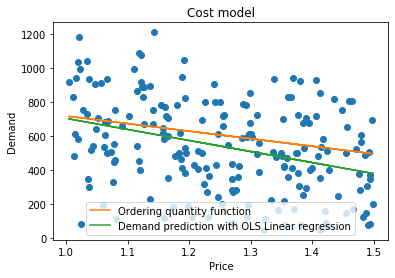

In [137]:
objC, betaC0, betaC1 = costModel(sampleSize = n, procurementCost = c)
print("Objective:",objC)
print('Estimation of a:', betaC0)
print('Estimation of b:', betaC1)

print('\nOrdering quantity - price function: D = ', round(betaC0,0),'+', round(betaC1,2),'* p')


#Plot
plt.plot(p,D,'o')
plt.plot(p, betaC0 + betaC1*p, label='Ordering quantity function')
plt.plot(p, coef1 + coef2*p, label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Cost model')
plt.show()

#### The service level model

In [38]:
# Service level model
def SLModel(sampleSize, procurementCost, nonStockOut):
    
    baseSLModel = gp.Model("Base Service level model")

    #### Variables
    betaSL0 = baseSLModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ a
    betaSL1 = baseSLModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ b

    waste = {}
    sales = {}
    unfulfilled = {} # binary variable = 1 if D > q (underage, unfulfilled demand existing), = 0 otherwise
    for i in range(sampleSize):
        waste[i] = baseSLModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = procurementCost)   
        sales[i] = baseSLModel.addVar(lb = 0, vtype = GRB.CONTINUOUS)
        unfulfilled[i] = baseSLModel.addVar(vtype = GRB.BINARY)

    #### Constraints
    for i in range(sampleSize):
        baseSLModel.addConstr(waste[i] >= betaSL0 + betaSL1 * p[i] - D[i])
        baseSLModel.addConstr(sales[i] <= D[i])
        baseSLModel.addConstr(sales[i] <= betaSL0 + betaSL1 * p[i])

        #if D < q then unfulfilled must equal to 1
        baseSLModel.addConstr(D[i] - unfulfilled[i]*np.max(D) <= betaSL0 + betaSL1 * p[i])

    #non-stockout (alpha level)    
    baseSLModel.addConstr(sum(unfulfilled[i] for i in range(sampleSize)) <= sampleSize*(1-nonStockOut)) 

    #fillrate (beta level)
    #baseSLModel.addConstr( sum(sales[i] for i in range(sampleSize)) >= fillRate * sum(D[i] for i in range(sampleSize)) )

    baseSLModel.Params.OutputFlag = 0
    baseSLModel.optimize()
    obj = baseSLModel.objVal; beta0 = betaSL0.x; beta1 = betaSL1.x;
    baseSLModel.dispose()
    
    return obj, beta0, beta1

Example of ordering quantity function with Service level model (alpha level)

Objective: 37480.86121921657
Estimation of a: 1957.1556277461339
Estimation of b: -804.3990742588601

Ordering quantity - price function: D =  1957.0 + -804.4 * p


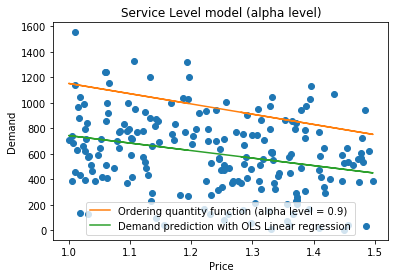

In [39]:
objSL, betaSL0, betaSL1 = SLModel(sampleSize = n, procurementCost = c, nonStockOut = alpha)
print("Objective:",objSL)
print('Estimation of a:', betaSL0)
print('Estimation of b:', betaSL1)

print('\nOrdering quantity - price function: D = ', round(betaSL0,0),'+', round(betaSL1,2),'* p')


# OLS Linear regression for comparison
reg = linear_model.LinearRegression().fit(p, D)
coef2 = reg.coef_
coef1 = reg.intercept_

#Plot
plt.plot(p,D,'o')
plt.plot(p, betaSL0 + betaSL1*p, label='Ordering quantity function (alpha level = ' +str(alpha)+')' )
plt.plot(p, coef1 + coef2*p, label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Service Level model (alpha level)')
plt.show()

## PRICE AND QUANTITY-SETTING NEWSVENDOR

**Reference:**   
Kyparisis, G.J. & Koulamas, C. (2018). *The price-setting newsvendor problem with nonnegative linear additive demand.* European Journal of Operational Research, 269(2), 695-698.   
DeYong, G. D. (2020). *The price-setting newsvendor: review and extensions.* International Journal of Production Research, 58(6), 1776-1804.
Huber et. al. (2019). *A data-driven newsvendor problem: From data to decision.* European Journal of Operational Research, 278(3), 904-915.

 ### Basic approach

From the previous model, we obtain the ordering quantity function of price: *q = beta0 + beta1 * p*. It means that at a certain selling price p, we can calculate a corresponding ordering quantity q, which also represents the estimated demand level at that selling price. So if the relationship between demand and price is captured completely, the expected profit is:  
$\Pi(p)  = p*q(p) - c*q(p) = beta1*p^2 + (beta0 - beta1*c)*p - beta0*c$  
By taking the first-order derivative, we can find the optimal price p* as $\frac{1}{2*beta1}(-beta0 + beta1*c) $   (1)  and so, the optimal ordering quantity q*.   

Below is the optimization model of this approach (hereinafter called as "Basic approach"). The optimal price from this model is similar to the one calculated from equation (1).

To make the problem logical, the lower bound of price is procurement cost per unit (p >= c) and the upper bound is -beta0/beta1 so that the expected demand is non-negative. Additionally, beta1 must be lessthan or equal to 0 so the profit function is concave and the problem is bounded. Otherwise, the problem is unbounded and we will choose the price as high as possible (i.e. maximum value of price in historical data).   

In [10]:
#Price-setting 
def NV_Price(procurementCost, beta0, beta1):
    if beta1 > 0: 
        return ubp * (beta0 + beta1*ubp) - procurementCost*(beta0 + beta1*ubp), ubp, (beta0 + beta1*ubp)
    else:
        pricingNV = gp.Model("Pricing NV model")

        #### Variables
        price = pricingNV.addVar(lb = procurementCost, ub = -beta0/beta1, vtype = GRB.CONTINUOUS)
        quantity = pricingNV.addVar()

        pricingNV.addConstr(quantity == beta0 + beta1*price)

        pricingNV.setObjective( price * quantity - procurementCost*quantity) #maximize expected profit
        pricingNV.modelSense = 0 #maximization

        pricingNV.Params.OutputFlag = 0
        pricingNV.Params.NonConvex = 2 #enable Quadratic Optimization mode of Gurobi
        pricingNV.optimize()

        return pricingNV.objVal, price.x, quantity.x

Example with results from Cost model:

In [11]:
objVal, price, quantity = NV_Price(procurementCost = c, beta0 = betaC0, beta1 = betaC1)

print('\n\n')
print('Optimal price from LP model:', price)
print('Optimal price from equation (1):', 0.5*(-betaC0+betaC1*c)/betaC1)




Optimal price from LP model: 1.3874078464837634
Optimal price from equation (1): 1.3874078464837634


### Data-driven approach

However, another approach is proposed here to make the solution more data-driven and robust. Using error terms obtained from historical data, we can generate the distribution of estimated demand at a certain price and then solve a data-driven quantity-setting newsvendor problem with this given price. In detail, demands at certain price p have the form of d(p) = beta0 + beta1 * p + u, with E[d(p)] = beta0 + beta1 * p, which is the estimated demand level from the previous model. u are error terms of all observations, which are independent with prices according to previously-mentioned assumptions.


In [12]:
#Newsvendor with Price-setting
def DDNV_Price(sampleSize, procurementCost, beta0, beta1):
    if beta1 > 0: 
        return ubp * (beta0 + beta1*ubp) - procurementCost*(beta0 + beta1*ubp), ubp, (beta0 + beta1*ubp)
    else:
        M = beta0*2

        pricingNV = gp.Model("Pricing NV model")

        #### Variables
         #same price range to avoid extrapolation ?
        price = pricingNV.addVar(lb = procurementCost, ub = -beta0/beta1, vtype = GRB.CONTINUOUS)
        quantity = pricingNV.addVar()

        sales = {}
        z = {} #binary variable = 1 if D = a - bp + u > 0, =0 otherwise ==> to ensure demand not negative: D = max(0, a-bp+u)

        for t in range(sampleSize):
            sales[t] = pricingNV.addVar()
            z[t] = pricingNV.addVar(vtype = GRB.BINARY)

        for t in range(sampleSize):
            pricingNV.addConstr(M*z[t] >= beta0 + beta1*price + u[t] ) #if a-bp+u > 0, z must equal to 1
            pricingNV.addConstr(sales[t] <= 0 + M*z[t] )
            pricingNV.addConstr(sales[t] <= beta0 + beta1*price + u[t] + M*(1-z[t]) )
            pricingNV.addConstr(sales[t] <= quantity)

        pricingNV.setObjective( price * sum(sales[t] for t in range(sampleSize)) / sampleSize - procurementCost*quantity) #maximize expected profit
        pricingNV.modelSense = 0 #maximization

        pricingNV.Params.OutputFlag = 0

        pricingNV.Params.NonConvex = 2 #enable Quadratic Optimization mode of Gurobi
        pricingNV.optimize()


        return pricingNV.objVal, price.x, quantity.x

Example run with results from Cost model

In [13]:
objValDD, priceDD, quantityDD = DDNV_Price(sampleSize = n, procurementCost = c, beta0 = betaC0, beta1 = betaC1)

print("Objective: ", objValDD)
print('Optimal price:', priceDD)
print('Optima ordering quantity:', quantityDD)

Objective:  443.2349005735817
Optimal price: 1.3508230281754816
Optima ordering quantity: 800.6586784714189


In [14]:
# method to combine two steps

In [15]:
def DDNV_main(sampleSize, procurementCost, estimationModel = 'cost', nonStockOut = None):

    if estimationModel == 'service' and nonStockOut is not None:
        (estObjVal, estBeta0, estBeta1) = SLModel(sampleSize, procurementCost)
    else:                
        (estObjVal, estBeta0, estBeta1) = costModel(sampleSize, procurementCost)
    print('\nOrdering quantity parameters:', estBeta0, estBeta1)

    (optV, optP, optQ) = NV_Price(procurementCost, estBeta0, estBeta1)
    print('Basic approach:', optV, optP, optQ)

    (optVDD, optPDD, optQDD) = DDNV_Price(sampleSize, procurementCost, estBeta0, estBeta1)
    print('Data-driven approach:', optVDD, optPDD, optQDD,'\n')

        
    return optV, optP, optQ, optVDD, optPDD, optQDD


In [16]:
DDNV_main(sampleSize = n, procurementCost = c, estimationModel = 'cost', nonStockOut = None)


Ordering quantity parameters: 1678.0171183797343 -737.6497021570741
Basic approach: 580.8937452794755 1.3874078464837634 654.5961336505986
Data-driven approach: 443.2349005735817 1.3508230281754816 800.6586784714189 



(580.8937452794755,
 1.3874078464837634,
 654.5961336505986,
 443.2349005735817,
 1.3508230281754816,
 800.6586784714189)

# ANALYSIS

## Sensitivity analysis

### 1. Procurement cost's effect       

Here we want to learn about the influence of procurement cost (c) on the optimal price and ordering quantity. To do so, for a certain sampling set, we run the model with different procurement costs from 0.1 to 0.9 (since c < p). Then this test is done for multiple times to get the average optimal price and ordering quantity over all test instances.

In [17]:
testRep = 50
costSet = [0.1*(i+1) for i in range(9)]
resultCost = pd.DataFrame(index = range(len(costSet)), columns = ['Procurement cost', 'Avg. opt. price (Basic)', 'Avg. opt. order qty (Basic)', 'Avg. opt. price (DD)', 'Avg. opt. order qty (DD)' ])

optPrice = np.zeros(shape=(len(costSet),testRep))
optQty = np.zeros(shape=(len(costSet),testRep))
optPriceDD = np.zeros(shape=(len(costSet),testRep))
optQtyDD = np.zeros(shape=(len(costSet),testRep))
for j in range(testRep):
    print('Test run = ', j)
    samplingDemand(sampleSize=n, coefVar=cv)
    
    for i in range(len(costSet)):
        print('Considering c =', costSet[i])
        optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize=n, procurementCost=costSet[i], estimationModel = 'cost', nonStockOut = None)
        
        optPrice[i,j] = optP
        optQty[i,j] = optQ
        optPriceDD[i,j] = optPDD
        optQtyDD[i,j] = optQDD    

for i in range(len(costSet)):
    resultCost.iloc[i,:] = [costSet[i], np.mean(optPrice[i,:]), np.mean(optQty[i,:]), 
                            np.mean(optPriceDD[i,:]), np.mean(optQtyDD[i,:])]

Test run =  0
Considering c = 0.1

Ordering quantity parameters: 1492.8706157779088 -758.3637595433987
Basic approach: 661.9468597897344 1.0342708047367317 708.5171199117846
Data-driven approach: 656.5181526170027 1.0440367537108615 910.5541448518204 

Considering c = 0.2

Ordering quantity parameters: 1476.0560964603649 -795.248354135866
Basic approach: 545.2717745778509 1.0280472501350093 658.5032128165958


KeyboardInterrupt: 

In [ ]:
resultCost

**Comment:** In general, when the procurement cost increases, the optimal price also increases to cover up the increase in cost, leading to the decrease in optimal ordering quantity. We can see that in general, the increase speed in optimal price in Data-driven approach is slower than that of Basic approach. It is because in Basic approach, the optimal price is calculated from a fixed equation so the change in cost is shown completely; meanwhile, in Data-driven approach, this influence is affected by the stochastic demand.

To generate out-of-sample demand observations, we will randomly draw 100,000 error terms in the same way as we dis previously with sampling set (u ~ N(0,sigma)) and D = a - b * p + u, with . This out-of-sample set will be used to evaluate the performance of the solution, which will be done for a significant number of times to obtain the average performance.

In [ ]:
def outOfSampleError(testSize):
    testU = np.random.normal(loc = 0, scale = sigma, size =(testSize,) )
    return testU

In [ ]:
def outOfSampleDemand(testU, chosenPrice):
    testD = a - b*chosenPrice + testU
    for i in range(len(testD)):
        if testD[i]<=0: testD[i] = 0
            
    return testD

In [ ]:
def testEvaluation(testD, chosenPrice, chosenQty, procurementCost):
    return sum( [chosenPrice * min(testD[i], chosenQty) for i in range(len(testD))] ) / len(testD) - procurementCost*chosenQty   
    

### 2. Sample size's effect       

Here we want to learn about the effect of sample size on performance of solution. To do so, from the same demand sampling set, we take subsets with different sizes and solve the problem with these subsets. The solutions are evaluated by generating out-of-sample demand based on each chosen price solution with same error terms. Then this test is done for multiple times to get the average objective value (i.e. expected profit).

In [23]:
import copy

testRep = 50

# Run the model with different sample sizes: 50, 100, 200, 500 and 700
sampleSizeSet = [50, 100, 200, 500, 700]
resultSize = pd.DataFrame(index = range(len(sampleSizeSet)), columns = ['Sample size','Avg. in-sample profit', 'Avg. out-of-sample profit'])
optValInSample = np.zeros(shape=(len(sampleSizeSet),testRep))
optValOutSample = np.zeros(shape=(len(sampleSizeSet),testRep))
for j in range(testRep):
    print('Test run = ', j)
    samplingDemand(sampleSize=max(sampleSizeSet), coefVar=cv)
    demandPool = copy.deepcopy(D)
    pricePool = copy.deepcopy(p)
    errorPool = copy.deepcopy(u)
    
    testU = outOfSampleError(testSize = 100000)
    
    for i in range(len(sampleSizeSet)):
        print('Considering n =', sampleSizeSet[i])
        if sampleSizeSet[i] != max(sampleSizeSet):
            lowElasticity = True
            while lowElasticity:
                idx = np.random.choice(max(sampleSizeSet), size = sampleSizeSet[i], replace = False)
                for k in range(len(idx)): 
                    D[k] = demandPool[k] 
                    p[k] = pricePool[k] 
                    u[k] = errorPool[k]
                
                reg = linear_model.LinearRegression().fit(p, D)
                coef2 = reg.coef_
                coef1 = reg.intercept_
                Q1 = coef1 + coef2*min(p)
                Q2 = coef1 + coef2*max(p)
                arcElasticity = ( (min(p) + max(p)) / (Q1 + Q2)) * ((Q2 - Q1) / (max(p) - min(p)) )
                if abs(arcElasticity) >= 1: lowElasticity = False

        else:
            D = demandPool; p = pricePool; u = errorPool;
        
        optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize=sampleSizeSet[i], procurementCost=c, estimationModel = 'cost', nonStockOut = None)
        
        testD = outOfSampleDemand(testU, chosenPrice = optPDD)
        testV = testEvaluation(testD, chosenPrice = optPDD, chosenQty = optQDD, procurementCost = c)
        
        optValInSample[i,j] = optVDD
        optValOutSample[i,j] = testV
        
for i in range(len(sampleSizeSet)):
    resultSize.iloc[i,:] = [sampleSizeSet[i], np.mean(optValInSample[i,:]), np.mean(optValOutSample[i,:])]

Test run =  0
Considering n = 50

Ordering quantity parameters: 2225.7270830615134 -1025.2841685768626
Basic approach: 715.5724000631947 1.3354196091562185 856.542499386541
Data-driven approach: 571.4848653851166 1.2979010316507251 975.3953243565061 

Considering n = 100

Ordering quantity parameters: 2066.294147795356 -913.1970148489106
Basic approach: 709.3540639359699 1.381351786195461 804.8478201854505
Data-driven approach: 543.147064860993 1.325397759568185 908.9917757256287 

Considering n = 200

Ordering quantity parameters: 1930.2570269867613 -807.2983680018355
Basic approach: 721.7069916895308 1.4455041057275941 763.303921492922
Data-driven approach: 567.6434236476736 1.3966939192338426 889.2633899842351 

Considering n = 500

Ordering quantity parameters: 1923.399782202878 -783.3443778182759
Basic approach: 748.7733002539381 1.4776846790933873 765.8637966468698
Data-driven approach: 605.4426993886258 1.439145680519091 906.5041142529587 

Considering n = 700

Ordering quantity


Ordering quantity parameters: 1629.855001225467 -675.0053333030978
Basic approach: 618.5782816358495 1.457290461876701 646.1761672869591
Data-driven approach: 510.2589728418365 1.4215076403905833 747.5299362667618 

Test run =  7
Considering n = 50

Ordering quantity parameters: 1075.721488314547 -10.044485143827695
Basic approach: 28532.992443577386 53.79786596382068 535.3496228713167
Data-driven approach: 30435.272562585433 56.99934905281985 1156.5980724835804 

Considering n = 100

Ordering quantity parameters: 1355.381849340377 -242.7695891868269
Basic approach: 1568.100782541102 3.041498420128155 616.9985273734817
Data-driven approach: 1420.7542298070832 3.0609237560553577 932.7917995844726 

Considering n = 200

Ordering quantity parameters: 1628.7303599541744 -470.23858941541863
Basic approach: 1032.535315525567 1.981812739974132 696.8055326232327
Data-driven approach: 904.2503103459728 1.9736542013165992 916.5733842460672 

Considering n = 500

Ordering quantity parameters: 17

Data-driven approach: 348.7748105176481 1.2648499730638105 594.8335064467421 

Considering n = 700

Ordering quantity parameters: 1352.8117553242096 -620.3806430184688
Basic approach: 438.0614814806659 1.3403078380573652 521.3107169074875
Data-driven approach: 354.49611843219117 1.3051191246848834 591.608127361019 

Test run =  14
Considering n = 50

Ordering quantity parameters: 1748.3130979694495 -904.9692084269449
Basic approach: 463.8753091247961 1.2159517040410912 647.9142468779885
Data-driven approach: 364.4434339541223 1.167459412138274 681.6865055240922 

Considering n = 100

Ordering quantity parameters: 1727.9848613694417 -890.8972709444868
Basic approach: 461.5849729213969 1.2198002888354986 641.2681129485993
Data-driven approach: 355.60694836154977 1.1662435956964192 675.873912527888 

Considering n = 200

Ordering quantity parameters: 1794.2742618257248 -923.3804819755524
Basic approach: 480.782355501329 1.2215790494005865 666.2920104189741
Data-driven approach: 375.154525

Data-driven approach: 457.1447550636896 1.3845622775201665 719.1248913384526 

Considering n = 500

Ordering quantity parameters: 1526.7539649957569 -624.3190922538028
Basic approach: 590.7394234179721 1.4727352838787522 607.2972094344278
Data-driven approach: 471.3915518190362 1.4299755001092485 712.4934867271176 

Considering n = 700

Ordering quantity parameters: 1486.5866841833617 -588.8112304815992
Basic approach: 603.4598304037639 1.5123627125517425 596.090534471281
Data-driven approach: 485.0961696516485 1.471341085657102 708.0573893685556 

Test run =  21
Considering n = 50

Ordering quantity parameters: 2146.815091938273 -973.4443660569234
Basic approach: 707.7724629954569 1.352690182816639 830.0464544549059
Data-driven approach: 602.1267674536728 1.3198965956631585 903.4987118139647 

Considering n = 100

Ordering quantity parameters: 2125.4323793125586 -958.0466380239639
Basic approach: 707.341032851687 1.35925308589173 823.2045301502885
Data-driven approach: 550.39593116376

Data-driven approach: 283.11856125013696 1.1662276215208922 530.0075133570076 

Considering n = 200

Ordering quantity parameters: 1346.910081460859 -735.9177184294234
Basic approach: 325.56136084836396 1.1651227424822705 489.4756111230735
Data-driven approach: 278.5454866456128 1.142788203192629 523.8719179808311 

Considering n = 500

Ordering quantity parameters: 1407.2092782441678 -792.9489077250582
Basic approach: 322.08408236183595 1.1373265758580842 505.3674121908194
Data-driven approach: 269.82098874268786 1.1117232805980968 537.6526734637225 

Considering n = 700

Ordering quantity parameters: 1393.2082763591873 -781.2311977895911
Basic approach: 321.669206167553 1.1416747566540602 501.29633873219575
Data-driven approach: 268.53712320280334 1.115894419667343 534.0020225676014 

Test run =  28
Considering n = 50

Ordering quantity parameters: 1440.875421075855 -811.3969452199887
Basic approach: 330.1686433957912 1.1378979823403206 517.5884742329303
Data-driven approach: 292.461

Data-driven approach: 428.3431542371685 1.1618735149399542 833.2226463844413 

Considering n = 100

Ordering quantity parameters: 1664.4084185548556 -794.4389081634204
Basic approach: 505.31508942415985 1.2975370739347512 633.5944822365727
Data-driven approach: 422.94381456286203 1.27589278965831 728.0172221421282 

Considering n = 200

Ordering quantity parameters: 1513.7620353255847 -689.952729894862
Basic approach: 494.98316482111625 1.3470041640071908 584.392835189077
Data-driven approach: 402.30993245838505 1.3115067801979998 663.2496172787962 

Considering n = 500

Ordering quantity parameters: 1535.0883542485158 -704.6223891369847
Basic approach: 496.35160301043646 1.3392985930582468 591.3885798400116
Data-driven approach: 414.2462576046458 1.313385413678616 674.9318388461217 

Considering n = 700

Ordering quantity parameters: 1529.000360209277 -702.0353562392113
Basic approach: 494.1500406534905 1.3389767492623876 588.9913410448356
Data-driven approach: 412.4866098180856 1.311

Data-driven approach: 609.8731525132221 1.501373134774454 888.7808433895852 

Considering n = 100

Ordering quantity parameters: 2062.959807525122 -861.6519908436832
Basic approach: 772.8934676987393 1.4470957123334576 816.0669060516404
Data-driven approach: 661.0787517237151 1.4381494820138951 987.9019934147507 

Considering n = 200

Ordering quantity parameters: 1799.7175557069652 -684.1118035801461
Basic approach: 776.4730436531647 1.5653680043879856 728.8308269584459
Data-driven approach: 644.2593317418675 1.5393321020120805 898.7690378791073 

Considering n = 500

Ordering quantity parameters: 1714.970168185552 -628.4829883793055
Basic approach: 780.4669555232928 1.6143727832697705 700.3643369979497
Data-driven approach: 628.925625981454 1.5720623728161607 859.5943450590153 

Considering n = 700

Ordering quantity parameters: 1642.3520077937242 -575.1680606620057
Basic approach: 797.7652091138073 1.6777148890216655 677.3839887313605
Data-driven approach: 646.1244279742451 1.634300

Data-driven approach: 289.3802071702653 1.430295904651495 455.7962350172777 

Considering n = 100

Ordering quantity parameters: 1360.5626791708557 -677.3148994450333
Basic approach: 385.4522832841544 1.2543797060168393 510.9526147241695
Data-driven approach: 301.44792955276785 1.2060188089057402 550.4448976633217 

Considering n = 200

Ordering quantity parameters: 1517.4838546911344 -789.9444322566545
Basic approach: 398.7724728653987 1.2105003799799559 561.2558192814037
Data-driven approach: 331.3592656624594 1.1826928380182635 613.0966431185641 

Considering n = 500

Ordering quantity parameters: 1597.6094913835343 -857.6704711126714
Basic approach: 398.18126748383975 1.1813655682414517 584.3871279135997
Data-driven approach: 334.841631140355 1.1563925648915774 631.077014753713 

Considering n = 700

Ordering quantity parameters: 1576.9420996138206 -843.5306518486695
Basic approach: 395.4904826360265 1.1847272065086296 577.5883868447429
Data-driven approach: 332.03222938033156 1.15

Data-driven approach: 557.7309877500861 1.7479779995515 720.1546984783827 

Considering n = 100

Ordering quantity parameters: 1912.9194730332927 -848.8591216045239
Basic approach: 652.5235349493514 1.37675909603084 744.2449561155154
Data-driven approach: 561.3619199425258 1.3605486195152727 867.6522276418177 

Considering n = 200

Ordering quantity parameters: 1498.9858469717028 -546.9765281399516
Basic approach: 686.4299693101765 1.620246957460089 612.7487914508636
Data-driven approach: 561.8594271059522 1.585622751918086 745.3681412363957 

Considering n = 500

Ordering quantity parameters: 1369.3260191339957 -451.2117902502365
Basic approach: 724.7681412189098 1.7673872322513828 571.8600620044388
Data-driven approach: 593.9773510296354 1.731331969073504 717.8526596295827 

Considering n = 700

Ordering quantity parameters: 1401.2621202582177 -461.79855312798287
Basic approach: 741.5296002023331 1.7671789850431514 585.1814218471131
Data-driven approach: 625.1616257599036 1.738372048

Data-driven approach: 382.4128866741128 1.2506019769988033 665.5623854160681 

Test run =  62
Considering n = 50

Ordering quantity parameters: 1941.2759596662288 -779.2414272666307
Basic approach: 772.428774412955 1.4956190672996574 775.8276230164568
Data-driven approach: 682.5336172492594 1.4853003393793864 916.9395713948875 

Considering n = 100

Ordering quantity parameters: 2176.070026173431 -1017.3479325612008
Basic approach: 683.2002925358297 1.3194817163952532 833.6980299464153
Data-driven approach: 566.6143004358507 1.2922453296672796 952.0206323595773 

Considering n = 200

Ordering quantity parameters: 1947.1393850708341 -852.7609438483943
Basic approach: 678.0058610206763 1.3916677787116154 760.3794565733187
Data-driven approach: 539.9147875873863 1.3499312416618165 876.6188606280193 

Considering n = 500

Ordering quantity parameters: 1606.0799518179172 -540.2955514110133
Basic approach: 825.804864814986 1.7362975899242052 667.9660880562053
Data-driven approach: 692.692952

Data-driven approach: 437.62434816599136 1.4594145769378057 648.7824613254922 

Test run =  69
Considering n = 50

Ordering quantity parameters: 1408.6748164170617 -485.5568446235828
Basic approach: 699.8739781134434 1.7005766235352997 582.9481970526352
Data-driven approach: 374.92650518981276 1.4816642424459963 618.9566625577373 

Considering n = 100

Ordering quantity parameters: 1021.4070092535885 -108.14652483665442
Basic approach: 2163.1175370167653 4.972329315696143 483.66687341763065
Data-driven approach: 1553.5749374296047 4.715636263651283 837.9610830164715 

Considering n = 200

Ordering quantity parameters: 1585.747587763582 -502.9912689673685
Basic approach: 884.8206642264374 1.826317210256046 667.125976639949
Data-driven approach: 668.9796129904821 1.7516024039946958 818.8703453900284 

Considering n = 500

Ordering quantity parameters: 1533.5569350320218 -452.65850216135345
Basic approach: 943.7822384476431 1.9439446930849584 653.6138419756726
Data-driven approach: 754.79

Data-driven approach: 515.5847827647692 1.561359329288106 697.790991826766 

Considering n = 700

Ordering quantity parameters: 1329.2785361338472 -449.98953419137564
Basic approach: 677.48389123785 1.727010502613734 552.1418845190796
Data-driven approach: 546.5713734539136 1.6760321953775958 689.0567031939282 

Test run =  76
Considering n = 50

Ordering quantity parameters: 1288.5160205783727 -493.9045947446276
Basic approach: 549.1217337529476 1.5544179324193141 520.7818616030294
Data-driven approach: 458.72290835108674 1.51538783530909 604.3518392982207 

Considering n = 100

Ordering quantity parameters: 1458.8482814655986 -631.0858869711029
Basic approach: 517.8166406665039 1.4058238835504164 571.6526689900235
Data-driven approach: 423.49672712414855 1.36581686810354 645.2083651092892 

Considering n = 200

Ordering quantity parameters: 1683.0086739166463 -814.9569533102022
Basic approach: 499.099147972663 1.2825751974264292 637.7650986307726
Data-driven approach: 411.94088337911

Data-driven approach: 387.93057040515544 1.2884557856305765 636.9622547563546 

Considering n = 700

Ordering quantity parameters: 1596.1082766074542 -785.0293511701742
Basic approach: 461.332291035562 1.2665914651651404 601.7968005111836
Data-driven approach: 381.54971183041124 1.2359225637284292 662.9191223603268 

Test run =  83
Considering n = 50

Ordering quantity parameters: 2347.9521567235424 -1108.7739234826347
Basic approach: 725.3228184126775 1.3088056352140192 896.7825974911127
Data-driven approach: 607.1302971756498 1.2790192956283477 996.9713288381627 

Considering n = 100

Ordering quantity parameters: 1478.0016751932903 -462.2552540980434
Basic approach: 840.8205629642927 1.8486856418508215 623.4370240721344
Data-driven approach: 680.7905861741853 1.7991901872027438 770.2330850036443 

Considering n = 200

Ordering quantity parameters: 1718.4331707039348 -648.6692476670084
Basic approach: 749.0376510741955 1.5745835045243928 697.0492734352155
Data-driven approach: 595.00

Data-driven approach: 307.0243974763319 1.147019652127989 584.0977000673644 

Considering n = 500

Ordering quantity parameters: 1563.7565672381947 -847.9327160879478
Basic approach: 383.0261813014715 1.172099441128299 569.8951045971105
Data-driven approach: 322.8944504825305 1.1455528570351476 611.564222777211 

Considering n = 700

Ordering quantity parameters: 1594.2705772927998 -870.0959256175785
Basic approach: 386.1060115231955 1.166146444520594 579.6113072420054
Data-driven approach: 326.7310454594608 1.1422123513809017 622.7466960281063 

Test run =  90
Considering n = 50

Ordering quantity parameters: 844.572373232043 -124.52223344185492
Basic approach: 1228.7181275739324 3.6412513046371435 391.1556282555578
Data-driven approach: 1061.1031804233783 3.635110780836845 709.6707252218774 

Considering n = 100

Ordering quantity parameters: 1003.8094058837522 -242.9169855246634
Basic approach: 801.2440260246426 2.316157300025105 441.17545656071036
Data-driven approach: 650.39712368

Data-driven approach: 441.41783598630093 1.5198287307365541 600.8093686864245 

Considering n = 200

Ordering quantity parameters: 1308.111531110587 -570.7640431179104
Basic approach: 458.14713729769744 1.3959302201000359 511.3647547758157
Data-driven approach: 397.23697150222944 1.38917637479142 615.1190463702932 

Considering n = 500

Ordering quantity parameters: 1367.7969701293075 -642.9707707686177
Basic approach: 425.6678460915443 1.3136540822020735 523.1557923724991
Data-driven approach: 354.6459886354056 1.2879928961732143 596.7049080278551 

Considering n = 700

Ordering quantity parameters: 1393.8989571740065 -661.4378379798285
Basic approach: 427.2328133832886 1.3036885532820968 531.590019092046
Data-driven approach: 355.31873840420286 1.2767440676025512 601.7923957200494 

Test run =  97
Considering n = 50

Ordering quantity parameters: 1269.6900251449513 -410.1520121700717
Basic approach: 690.8432580777724 1.7978285946070984 532.3070095299577
Data-driven approach: 579.1685

In [24]:
resultSize

,Sample size,Avg. out-of-sample profit
0,50,311.061
1,100,327.18
2,200,371.422
3,500,386.272
4,700,382.597


**Comment:** As expected, the more historical data we have, the higher the out-of-sample profit is, which means better solution we have. With more data, the relationship between demand and price is capture more correctly and so the estimated demand is nearer to the true demand. 

## Basic approach vs Data-driven approach in Price and Quantity-setting Newsvendor

Here we want to compare the performance of Basic approach with Data-driven approach to solve the Price and Quantity-setting Newsvendor. In basic approach, the vendor takes the optimal price as given from the ordering quantity function, while in Data-driven approach, the vendor use the historical data to make the solution more robust.

For a certain sampling set, we runs both approaches to obtain the solution of optimal price and ordering quantity. Two solutions are evaluated with the same out-of-sample demand set to get the profit of each solution when dealing with unknown demand. Then this test is done for multiple times to get the average performance of each solution.

In [25]:
testRep = 200

resultDD = pd.DataFrame(index = range(testRep), columns = ['Out-of-sample profit (Basic)', 'Out-of-sample profit (Data-driven)'])

for j in range(testRep):
    print('Test run = ', j)
    samplingDemand(sampleSize=n, coefVar=cv)
    testU = outOfSampleError(testSize = 100000)
    
    optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize=n, procurementCost=c, estimationModel = 'cost', nonStockOut = None)

    #Basic approach
    testD = outOfSampleDemand(testU, chosenPrice = optP)
    testV = testEvaluation(testD, chosenPrice = optP, chosenQty = optQ, procurementCost = c)
    
    #Data-driven approach
    testDDD = outOfSampleDemand(testU, chosenPrice = optPDD)
    testVDD = testEvaluation(testDDD, chosenPrice = optPDD, chosenQty = optQDD, procurementCost = c)
    
    resultDD.iloc[j,:] = [testV, testVDD]
    
print(resultDD)
print('\n\nThe average out-of-sample profit from Basic approach:', np.mean(resultDD.iloc[:,0]) )
print('The average out-of-sample profit from Data-driven approach:', np.mean(resultDD.iloc[:,1]) )

Test run =  0

Ordering quantity parameters: 1595.106642513733 -671.9034989055052
Basic approach: 589.917691789839 1.437005756862463 629.5774465304904
Data-driven approach: 476.9323401172185 1.394825635872418 715.1379394362253 

Test run =  1

Ordering quantity parameters: 1607.1616598567514 -669.9911484600054
Basic approach: 603.8910189854148 1.449390218475916 636.0830428133743
Data-driven approach: 479.3791868595591 1.4049510525758635 744.9047708295462 

Test run =  2

Ordering quantity parameters: 1513.8492707181197 -644.4436272209721
Basic approach: 550.8534558158926 1.4245397167214429 595.813728553817
Data-driven approach: 461.99891434377906 1.3934251508387538 685.4143929228366 

Test run =  3

Ordering quantity parameters: 1431.653611761249 -684.4400770802115
Basic approach: 433.51695429806637 1.2958575262487657 544.7167866105717
Data-driven approach: 348.8294212557024 1.250957839724194 589.8117592471374 

Test run =  4

Ordering quantity parameters: 1449.118912700795 -829.404295

Data-driven approach: 513.6432046015525 1.411381407623122 790.9971688899664 

Test run =  36

Ordering quantity parameters: 1711.444597214608 -764.2422040000449
Basic approach: 578.0565852293006 1.3697003961943637 664.6617476072927
Data-driven approach: 474.32166889025746 1.3371686256947535 762.981790506409 

Test run =  37

Ordering quantity parameters: 1796.4865414280061 -596.5476486376599
Basic approach: 940.6798228246159 1.7557360007458376 749.1063585545882
Data-driven approach: 801.3613806686203 1.7410513622472836 945.3648639836331 

Test run =  38

Ordering quantity parameters: 1333.5459641107263 -731.0476470901251
Basic approach: 320.45341653011496 1.1620786924209359 484.0110702828317
Data-driven approach: 263.3688059124271 1.131289566019555 517.4543863255092 

Test run =  39

Ordering quantity parameters: 1641.0415662849186 -801.4620674144971
Basic approach: 479.8637015304603 1.273779934825169 620.1552662888353
Data-driven approach: 382.3167031669177 1.2346729148777338 690.2583


Ordering quantity parameters: 1313.9564866656117 -476.03003592200884
Basic approach: 607.9711135432917 1.6301193070944011 537.9707343523038
Data-driven approach: 518.2570495517583 1.6097448402126608 664.1222487685836 

Test run =  72

Ordering quantity parameters: 1550.3974222826946 -553.8224868166697
Basic approach: 732.0789090317611 1.6497241527644204 636.7430894371798
Data-driven approach: 589.1439148595814 1.6026789444364724 782.8308574045657 

Test run =  73

Ordering quantity parameters: 1141.1077930940114 -380.7790255548084
Basic approach: 593.431615102226 1.7483858307733433 475.35914015830366
Data-driven approach: 480.29757342934784 1.702622322540299 583.8763007508421 

Test run =  74

Ordering quantity parameters: 2155.6367844231618 -1026.21128270233
Basic approach: 657.2497792211407 1.3002889710716816 821.2655715359983
Data-driven approach: 546.0313137623516 1.2724172055911822 914.344425977984 

Test run =  75

Ordering quantity parameters: 1371.0540117311264 -515.6497361223

Data-driven approach: 701.7192010241588 1.8898841625587828 776.6389255990017 

Test run =  107

Ordering quantity parameters: 1290.0993922213645 -597.1679205507111
Basic approach: 411.56884770386637 1.3301814262156184 495.7577159730046
Data-driven approach: 339.87097149054824 1.3061103758206274 570.8742138765249 

Test run =  108

Ordering quantity parameters: 1260.0496194490333 -345.58478431739417
Basic approach: 855.1651663643358 2.0730687180541065 543.6286136451681
Data-driven approach: 717.3503635857487 2.048390065881887 724.0007996813008 

Test run =  109

Ordering quantity parameters: 1489.264615305247 -737.0125346085189
Basic approach: 426.07798905384584 1.260338729243122 560.3791740004938
Data-driven approach: 369.7546095135175 1.2453335226786444 628.9516437534502 

Test run =  110

Ordering quantity parameters: 2068.79993066026 -926.4820962643206
Basic approach: 695.5933999315628 1.3664813324520206 802.7794412640501
Data-driven approach: 538.1483919819556 1.3137862552760866 90


Ordering quantity parameters: 1606.691759379799 -984.4483781322976
Basic approach: 315.41470148927806 1.066036571886088 557.233785156825
Data-driven approach: 265.0361144915181 1.0383992249404306 570.5540050061466 

Test run =  143

Ordering quantity parameters: 1545.625081516926 -849.4530750480797
Basic approach: 369.771321933898 1.159776612103878 560.449271996443
Data-driven approach: 305.9490461951604 1.1304046615574865 597.0557137173753 

Test run =  144

Ordering quantity parameters: 1087.3296915597418 -170.15188596971495
Basic approach: 1475.905733879434 3.445173786534678 501.12687428744226
Data-driven approach: 1266.5742047168055 3.4032050510834275 787.0873757314591 

Test run =  145

Ordering quantity parameters: 1334.2785150176433 -564.2098206438857
Basic approach: 490.5397132023234 1.4324311330622908 526.0868023478503
Data-driven approach: 405.7016605471689 1.4059338030683743 624.1507878127161 

Test run =  146

Ordering quantity parameters: 1592.3009483487124 -974.866113498


Ordering quantity parameters: 1541.753650129547 -725.0939713921061
Basic approach: 479.4303953371363 1.313140579675168 589.6033322167469
Data-driven approach: 400.77841010185676 1.2890083268198558 673.749587415126 

Test run =  178

Ordering quantity parameters: 1565.0651746202186 -723.9784383551253
Basic approach: 499.8048553257764 1.330878305005904 601.537977721328
Data-driven approach: 428.5699428304456 1.3096378686117522 684.279919114959 

Test run =  179

Ordering quantity parameters: 1606.7171633103262 -813.4302285851908
Basic approach: 442.5717372685334 1.2376183026200718 600.0010245088654
Data-driven approach: 369.210775680939 1.2141082082196906 672.0051515696691 

Test run =  180

Ordering quantity parameters: 1402.423045549238 -517.5836732797943
Basic approach: 631.729906443756 1.6047790608061925 571.8156044546704
Data-driven approach: 543.5404715745954 1.590430732599486 709.2202506686594 

Test run =  181

Ordering quantity parameters: 1673.2695372783521 -697.6516770703429


Ordering quantity parameters: 2200.845140709119 -1014.0331004284551
Basic approach: 707.3376827555384 1.3351939348820099 846.9142952474456
Data-driven approach: 551.6545653444942 1.2879724106570516 955.098811331321 

Test run =  213

Ordering quantity parameters: 1491.077853990798 -750.7637395587047
Basic approach: 414.5037458512649 1.2430406700696857 557.8479921057227
Data-driven approach: 342.99817643729443 1.2161293869801395 622.3127020641064 

Test run =  214

Ordering quantity parameters: 1488.1803423720962 -558.8731627148532
Basic approach: 653.5747184094739 1.581411527387469 604.3718805073349
Data-driven approach: 535.9267138535214 1.5377727291135508 711.484591986869 

Test run =  215

Ordering quantity parameters: 1378.4121942601323 -618.7225412775657
Basic approach: 461.78610000849983 1.3639178729563703 534.5254618106749
Data-driven approach: 390.24921918393125 1.335127021557851 601.946383522503 

Test run =  216

Ordering quantity parameters: 1517.066723641359 -545.8912264148


Ordering quantity parameters: 1935.3868692413507 -818.5439858650706
Basic approach: 711.3321507181015 1.432213114177337 763.0574381544079
Data-driven approach: 598.306793662191 1.4025559875438451 881.2868758801922 

Test run =  248

Ordering quantity parameters: 1484.5391337157616 -537.7896793007488
Basic approach: 686.9744374860469 1.63022278118651 607.8221470326937
Data-driven approach: 548.26962747346 1.5786329355427737 728.8074942028478 

Test run =  249

Ordering quantity parameters: 1659.835601506302 -847.5444113751422
Basic approach: 450.67040085958126 1.229202729219355 618.0316979093654
Data-driven approach: 384.3619476871882 1.212735633331511 695.0008760359847 

Test run =  250

Ordering quantity parameters: 1594.1415529624821 -593.2815107471523
Basic approach: 709.4053536337716 1.5934950559599363 648.7503987944531
Data-driven approach: 615.4342867045615 1.5884209074118907 790.7872563162387 

Test run =  251

Ordering quantity parameters: 1581.63435065222 -898.7239632025853
B

Data-driven approach: 485.1672592436815 1.3787200904395358 768.5970231030847 

Test run =  283

Ordering quantity parameters: 1552.7256891281418 -558.1678121738024
Basic approach: 726.5572091979393 1.6409129613556552 636.8208915206202
Data-driven approach: 588.5332188031009 1.6066164213142677 767.7647566126344 

Test run =  284

Ordering quantity parameters: 1309.3228892544025 -523.974472345045
Basic approach: 523.3613601952899 1.4994147695731577 523.66782654094
Data-driven approach: 445.0415918292222 1.4854318076062625 631.0933736671816 

Test run =  285

Ordering quantity parameters: 1617.8206977133282 -809.6969947586811
Basic approach: 454.2753549497786 1.2490284687888071 606.486100166994
Data-driven approach: 377.6425382652642 1.226099939461081 687.1433176445303 

Test run =  286

Ordering quantity parameters: 1306.8122157763603 -463.7938569349857
Basic approach: 622.8213556590263 1.6588287244817352 537.4576436544336
Data-driven approach: 507.0675153601377 1.6231262014799612 666.14


Ordering quantity parameters: 1459.504488612354 -813.9214042225316
Basic approach: 340.2811428580993 1.1465880987037635 526.271893250544
Data-driven approach: 281.9757433802695 1.1176784368443913 559.3686432596728 

Test run =  319

Ordering quantity parameters: 1570.6765682085352 -886.0523433517752
Basic approach: 358.7811223403638 1.136333962092437 563.8251982663239
Data-driven approach: 312.35881076231306 1.1181183247154323 599.0179289562404 

Test run =  320

Ordering quantity parameters: 1479.5874017927713 -807.0547447315532
Basic approach: 358.68235534491936 1.1666586352731991 538.0300147134973
Data-driven approach: 295.44827065228185 1.1360697660484307 574.4623653440011 

Test run =  321

Ordering quantity parameters: 1718.1884872679657 -767.7089641155617
Basic approach: 579.7923824920476 1.3690363585550958 667.1670026050924
Data-driven approach: 499.78855697946386 1.3494477278042363 762.6210698149997 

Test run =  322

Ordering quantity parameters: 1742.5025173460247 -875.5827

Data-driven approach: 677.149704952507 1.6084374136426505 863.5330950979296 

Test run =  354

Ordering quantity parameters: 1237.0078112223528 -380.4729350660569
Basic approach: 719.9791003392365 1.8756186672089905 523.3856718446624
Data-driven approach: 548.1507191500746 1.8012080719146941 675.0148733212787 

Test run =  355

Ordering quantity parameters: 1702.5242285398606 -594.3634765230898
Basic approach: 830.7153757726451 1.6822248050126618 702.6712451391577
Data-driven approach: 682.1670061860489 1.6453747313911014 860.3377578481814 

Test run =  356

Ordering quantity parameters: 1629.7225960372637 -793.5034295458745
Basic approach: 478.9573483367793 1.276915911989165 616.4854406321631
Data-driven approach: 403.6292093189719 1.2570376391927973 701.7323346314407 

Test run =  357

Ordering quantity parameters: 1587.6944693414064 -787.6948742899777
Basic approach: 452.3549609132985 1.2578105883147597 596.9235160982088
Data-driven approach: 374.5549549524981 1.2264530332914774 662

Ordering quantity parameters: 1896.2084156787887 -1031.3461825541099
Basic approach: 461.9878887807412 1.1692880372053462 690.2676622008669
Data-driven approach: 391.70935120493675 1.1418557989361828 731.8679297983049 

Test run =  390

Ordering quantity parameters: 1586.1224926467673 -660.9571801884064
Basic approach: 596.3478638540587 1.4498678130666816 627.821951276282
Data-driven approach: 480.86550777793616 1.4124124634943924 744.2804779236192 

Test run =  391

Ordering quantity parameters: 1502.3693732523416 -574.7390493512672
Basic approach: 642.1282117979026 1.5570013034159855 607.499924288354
Data-driven approach: 535.9722433196537 1.5256468345244576 713.8986976288211 

Test run =  392

Ordering quantity parameters: 1506.036141087183 -737.3352575174465
Basic approach: 438.6088687769163 1.2712695824134979 568.68425616423
Data-driven approach: 352.72524490590627 1.2370082246787053 640.0250989697929 

Test run =  393

Ordering quantity parameters: 1597.7012542807415 -778.2255422

Data-driven approach: 643.5959426818392 1.5022723091169254 929.5942227308094 

Test run =  425

Ordering quantity parameters: 1700.9468079632006 -677.5098327347281
Basic approach: 684.7010404408295 1.5052930789929866 681.0959457979183
Data-driven approach: 548.8797710156557 1.4621465929006108 802.4712371103769 

Test run =  426

Ordering quantity parameters: 1765.9542804048322 -688.363687551663
Basic approach: 734.1456624287189 1.5327189408304558 710.8862183145002
Data-driven approach: 568.6067405298909 1.472644401852722 834.1626793585501 

Test run =  427

Ordering quantity parameters: 1399.738181482907 -888.4475592961978
Basic approach: 256.9109911329458 1.0377438385849913 477.7572009174041
Data-driven approach: 223.5441369188723 1.0192254794409563 497.46656724637387 

Test run =  428

Ordering quantity parameters: 1649.4175195951016 -561.2812064626763
Basic approach: 834.4971402916905 1.719332573942847 684.3884581818818
Data-driven approach: 707.3126362246416 1.6964075005975883 850.

Data-driven approach: 296.8865984984278 1.0815569725716054 597.8959894969801 

Test run =  461

Ordering quantity parameters: 1642.762107600676 -650.6120047673186
Basic approach: 666.9453439436356 1.5124744821517584 658.7280526085083
Data-driven approach: 558.6612380537484 1.4868430481060697 788.0049511441455 

Test run =  462

Ordering quantity parameters: 1349.856465107947 -454.6487557367468
Basic approach: 692.8855907900314 1.7345047391810617 561.2660436197868
Data-driven approach: 595.8959517557423 1.7128623803325027 686.4083962753871 

Test run =  463

Ordering quantity parameters: 1343.6683918473611 -665.8612156200585
Basic approach: 383.5599837157424 1.2589703081715908 505.36889201866603
Data-driven approach: 315.3759974827507 1.2311600729167624 570.2655792955137 

Test run =  464

Ordering quantity parameters: 1707.1144100185008 -862.5562797899047
Basic approach: 471.7831828200375 1.2395669708846753 637.9181350617741
Data-driven approach: 380.82571577274575 1.2048701396793664 7

Data-driven approach: 371.10452293833987 1.3574607277302047 572.544742008487 

Test run =  496

Ordering quantity parameters: 1979.2029649925203 -831.997728608637
Basic approach: 734.2589337638257 1.439428105953109 781.6020503441011
Data-driven approach: 567.7729814271531 1.3861587521015533 894.6328654465337 

Test run =  497

Ordering quantity parameters: 1647.0844462000423 -732.9762919018106
Basic approach: 559.3383109147895 1.3735591549123976 640.2981501245686
Data-driven approach: 460.88622438026886 1.33785580663998 715.2002563502797 

Test run =  498

Ordering quantity parameters: 1943.5073026819473 -908.4619067920363
Basic approach: 610.3569197453849 1.3196691232463815 744.6381746429647
Data-driven approach: 503.70622015717515 1.2876054553941627 834.4595932696523 

Test run =  499

Ordering quantity parameters: 1576.6356075752017 -840.770425514907
Basic approach: 397.52676085669924 1.1876136218216964 578.1251974088742
Data-driven approach: 325.77677921596427 1.1600389404775915 63

Data source: https://www.dunnhumby.com/careers/engineering/sourcefiles  
Breakfast at the Frat contains sales and promotion information on the top five products from each of the top three brands within four selected categories (mouthwash, pretzels, frozen pizza, and boxed cereal), gathered from a sample of stores over 156 weeks.

In [ ]:
data = pd.read_excel('dunnhumby - Breakfast at the Frat.xlsx', sheet_name = 'dh Transaction Data', skiprows = range(1), header = 0)

In [ ]:
stores = data.loc[((data['STORE_NUM'] == 15547) | (data['STORE_NUM'] == 21213) | (data['STORE_NUM'] == 26981)), ['WEEK_END_DATE', 'UPC', 'UNITS', 'PRICE', 'BASE_PRICE']]

In [ ]:
stores

To evaluate the performance of our approach, we will choose one product with high variance in demand and one product with low variance to implement our method. 

In [ ]:
highVar = data.loc[((data['UPC'] == 3000006610) & ((data['STORE_NUM'] == 15547) | (data['STORE_NUM'] == 21213) | (data['STORE_NUM'] == 26981))), ['WEEK_END_DATE', 'UNITS', 'PRICE', 'BASE_PRICE']]
midVar = data.loc[((data['UPC'] == 7192100339) & ((data['STORE_NUM'] == 15547) | (data['STORE_NUM'] == 21213) | (data['STORE_NUM'] == 26981))), ['WEEK_END_DATE', 'UNITS', 'PRICE', 'BASE_PRICE']]
lowVar = data.loc[((data['UPC'] == 1111009477) & ((data['STORE_NUM'] == 15547) | (data['STORE_NUM'] == 21213) | (data['STORE_NUM'] == 26981))), ['WEEK_END_DATE', 'UNITS', 'PRICE', 'BASE_PRICE']]

In [ ]:
plt.plot(lowVar.PRICE, lowVar.UNITS, 'bo')
plt.plot(lp, coef1 + coef2*lp, 'g-')

For each product, we assume that the cost per unit equal to 30% of the average base price.
We set the train set (historical data) as demands 

In [ ]:
plt.plot(midVar.PRICE, midVar.UNITS, 'bo')


In [ ]:
lp = np.array(lowVar['PRICE'])
lp = lp.reshape(-1, 1)
lu = list(lowVar['UNITS'])
reg = linear_model.LinearRegression().fit(lp,lu)
coef2 = reg.coef_
coef1 = reg.intercept_
print(coef1, coef2)

